In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from functools import partial

import ipykernel
ipykernel.__version__

'6.12.1'

In [32]:
%matplotlib inline

In [33]:
path = pd.read_csv('path.csv')
tracker = pd.read_csv('tracker.csv')

In [34]:
# Quick overviews
print(f"path info:")
path.info()
print(f"tracker info:")
tracker.info()
print(f"path first entries:", f"{path.iloc[:10]}", sep='\n')
print(f"tracker first entries:", f"{tracker.iloc[:10]}", sep='\n')
print(f"path last entries:", f"{path.iloc[-10:]}", sep='\n')
print(f"tracker last entries:", f"{tracker.iloc[-10:]}", sep='\n')
# index==3180 first entry in index column that's the same for both path and tracker datasets 
t_diff_same_index = (path.loc[path['index'] == 3180]['t_pth'].values[0] - tracker.loc[tracker['index'] == 3180]['t_trk'].values[0])*1e-9
print(f"Diff for same index: {t_diff_same_index} sec")
# Not sure what the 'index' column is for...
print(f"Num entries in tracker is {len(tracker)/len(path)} times larger than path")

path info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145841 entries, 0 to 145840
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  145841 non-null  int64  
 1   index       145841 non-null  int64  
 2   x_pth       145841 non-null  float64
 3   y_pth       145841 non-null  float64
 4   z_pth       145841 non-null  float64
 5   t_pth       145841 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 6.7 MB
tracker info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546943 entries, 0 to 546942
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  546943 non-null  int64  
 1   index       546943 non-null  int64  
 2   x_trk       546943 non-null  float64
 3   y_trk       546943 non-null  float64
 4   z_trk       546943 non-null  float64
 5   t_trk       546943 non-null  int64  
dtypes: float64(3), int64(3)
memo

In [35]:
# Unifiy colum names
column_names = ['unnamed', 'index', 'x', 'y', 'z', 't']
path.columns = column_names
tracker.columns = column_names

In [36]:

def df_mean_of_diffs(df, column, scale=1):
    tdata = df[[column]]
    diff = tdata.diff()
    return diff.mean().values[0]*scale

def df_var_of_diffs(df, column, scale=1):
    tdata = df[[column]]
    diff = tdata.diff()
    return diff.var().values[0]*scale

def df_start(df, column, scale=1):
    return df[[column]].iloc[0].values[0]*scale

def df_end(df, column, scale=1):
    return df[[column]].iloc[-1].values[0]*scale
    
def df_min(df, column, scale=1):
    return df[[column]].min().values[0]*scale

def df_max(df, column, scale=1):
    return df[[column]].max().values[0]*scale

In [37]:
#what's in unnamed and index?
#max time, time step
#max movement for both dfs
#etc

# Looks like nano sec resolution (1e-9) with unix epoch 1/1/1970
print(f'time step path: {df_mean_of_diffs(path, "t", 1e-9 )} sec, var: {df_var_of_diffs(path, "t", 1e-9)}')
print(f'time step tracker: {df_mean_of_diffs(tracker, "t", 1e-9 )} sec, var: {df_var_of_diffs(tracker, "t", 1e-9)}')

# Variance of tracker timestamps is not null, so investigate further

start_time_path = df_start(path, "t", 1e-9)
end_time_path = df_end(path, "t", 1e-9)
print(f'start time path: {start_time_path} sec, end: {end_time_path} sec')
print(f'start time tracker based on path: {df_start(tracker, "t", 1e-9)-start_time_path} sec, end: {df_end(tracker, "t", 1e-9)-end_time_path} sec')

# Something weird is going on with the timestamp of the tracker data
# Let's investigate
print(f'min of tracker timestamp diff: {tracker[["t"]].diff().min().values[0]*1e-9} sec, max: {tracker[["t"]].diff().max().values[0]*1e-9} sec')

# tracker time steps are between 0.0036 sec and 0.072 sec
# path time steps are constant   0.05 sec
# Both datasets start at roughly the same time (+0.28 sec) and end roughly at the same time (+1.38 sec)


time step path: 0.05 sec, var: 0.0
time step tracker: 0.0133343082447499 sec, var: 1565.1635220479013
start time path: 1633969004.3500001 sec, end: 1633976296.3500001 sec
start time tracker based on path: 0.2838711738586426 sec, end: 1.3770909309387207 sec
min of tracker timestamp diff: 0.0036330000000000004 sec, max: 0.07236300000000001 sec


In [38]:
START = 0
END = 100
SKIP = 5

In [39]:
def get_data_slices(df, start, end, skip):
    xdata = df[['x']].iloc[start:end:skip]
    ydata = df[['y']].iloc[start:end:skip]
    zdata = df[['z']].iloc[start:end:skip]
    tdata = df[['t']].iloc[start:end:skip]
    return xdata, ydata, zdata, tdata

# computationally intense...
# Either cache some timestamps, or since timestamps are already sorted
# memorize them, so we can use them in future calls as 'quick' known
# entry points / hints. 
#@cache available in >= 3.9
# !!! cache only works with the same df for now...
def find_closest_timestamp(df, timestamp, _cache = {}):
    if timestamp in _cache:
        id = _cache[timestamp]
    else:
        id = df[['t']].sub(timestamp).abs().idxmin().values[0]
        _cache[timestamp] = id

    return id

def update_plot(slider, time_step, val):
    path_index = int(slider.val / time_step)
    slice_path = get_data_slices(path, START, path_index, SKIP)
    # because t_steps are different, we have to look for the
    # correct index corresponding to path ind's
    tracker_index = find_closest_timestamp(tracker, path[['t']].iloc[path_index].values[0])
    slice_tracker = get_data_slices(tracker, START, tracker_index, SKIP)
    ax3d.clear()
    ax3d.scatter3D(slice_path[0], slice_path[1], slice_path[2], c=slice_path[3], cmap='hsv')
    ax3d.scatter3D(slice_tracker[0], slice_tracker[1], slice_tracker[2], c=slice_tracker[3], cmap='hsv')
    fig.canvas.draw()


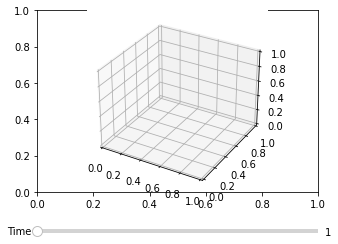

In [40]:
fig = plt.figure()
ax = plt.subplot(111, label='a')
fig.subplots_adjust(left=0.25, bottom=0.25)
ax3d = plt.axes(projection='3d', label='b')

t_bias = df_start(path, "t", 1e-9)
t_end = (df_end(path, "t", 1e-9) - t_bias)
t_step = df_mean_of_diffs(path, "t", 1e-9 )

axcolor = 'lightgoldenrodyellow'
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
slider = Slider(axfreq, 'Time', 1., t_end, valinit=0, valstep=10)

slider.on_changed(partial(update_plot, slider, t_step))

plt.show()


### Observations:
- tracker has more time steps than path
    - Could get rid of some rows in tracker to avoid costly call to `find_closest_timestamp` and only keep the rows with timestamps closest to the timestamps of path
- values in 'index' columns increas with each entry
- Recording of ~ 2hrs
- Tracker circles look smooshed

#### TODO
- Remove rows in tracker (align timestamps as much as possible)
- coordinate transformation?
    - shift by mean?
    - normalize with var?
- Plot error/diff for each timestamp for each axis


In [72]:
print(f"path time stamps are ordered: {path['t'].is_monotonic_increasing}")
print(f"tracker tiem stamps are ordered: {tracker['t'].is_monotonic_increasing}")
print()

# Merge tracker data with path data -> for each path timestamp find closest tracker timestamp and merge those two rows
# Gets rid of unnecessary samples in tracker
# Choose only columns related to tracker samples and rename the columns
tracker_filtered = pd.merge_asof(path.iloc[6:], tracker, "t", suffixes=('_path', '_tracker'))
tracker_filtered = tracker_filtered[['unnamed_tracker', 'index_tracker',  'x_tracker', 'y_tracker', 'z_tracker', 't']]
tracker_filtered.columns = column_names

# Can't find closest time stamp for first 6 samples
# TODO causes SettingWithCopyWarning later on in sub_mean()...
path_filtered = path.iloc[6:,:]

print(len(path_filtered))
print(len(tracker_filtered))


path time stamps are ordered: True
tracker tiem stamps are ordered: True

145835
145835


In [84]:
tracker_means = tracker_filtered[['x', 'y', 'z']].mean()
path_means = path_filtered[['x', 'y', 'z']].mean()
def sub_mean(df, means):
    df[['x', 'y', 'z']] = df[['x', 'y', 'z']] - means
    return df
tracker_shifted = sub_mean(tracker_filtered, tracker_means)
path_shifted = sub_mean(path_filtered, path_means)

x    6.080552e-17
y    2.728453e-17
z   -3.118232e-17
dtype: float64
x    6.369232e-17
y   -2.837591e-16
z    0.000000e+00
dtype: float64
145835
145835
145835
145835


/tmp/ipykernel_25846/4221815329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'z']] = df[['x', 'y', 'z']] - means


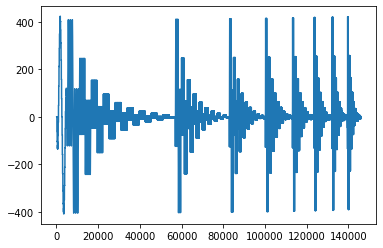

In [86]:
plt.plot(path_shifted['index'].values, (tracker_shifted['x'].values-path_shifted['x'].values))

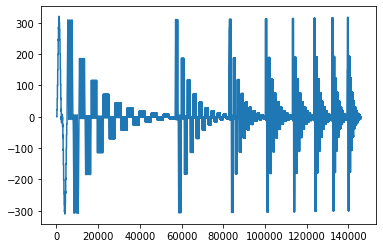

In [87]:
plt.plot(path_shifted['index'].values, (tracker_shifted['y'].values-path_shifted['y'].values))

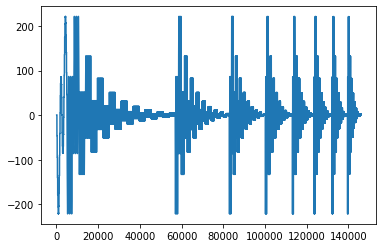

In [88]:
plt.plot(path_shifted['index'].values, (tracker_shifted['z'].values-path_shifted['z'].values))